## Census Income Data

My project topic will be on Income of Adults, with information extracted from the 1994 US Census database. The purpose of my project will be to determine whether or not a person has an income that exceeds $50K per year dependent on various factors. 

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
import sklearn.preprocessing as preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.metrics import plot_roc_curve, auc

### Load Data Census Income

In [2]:
path = "C:/Users/Kanna/Documents/Rutgers Grad/Spring 2023/BINF5125 MLT/Project Census Income/"

# Column names to be added
column_names=["age", "workclass", "fnlwgt", "education", "education_num", 
              "marital_status", "occupation", "relationship", "race",
              "sex", "capital_gain", "capital_loss", "hours_per_week", 
              "native_country", "income_grp"]

# Add column names while reading a CSV file
ci = pd.read_csv(path+"census_income_data.csv", names = column_names)
  
# Print data to view - first 10 rows
print(ci.head(10))

   age          workclass  fnlwgt   education  education_num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   
5   37            Private  284582     Masters             14   
6   49            Private  160187         9th              5   
7   52   Self-emp-not-inc  209642     HS-grad              9   
8   31            Private   45781     Masters             14   
9   42            Private  159449   Bachelors             13   

           marital_status          occupation    relationship    race  \
0           Never-married        Adm-clerical   Not-in-family   White   
1      Married-civ-spouse     Exec-managerial         Husband   White   
2                Divorced   Handlers-cleaners   Not-in-family   White   
3  

### Data Cleaning: Pre-processing and Feature Selection

**Initial Feature Selection**

In [3]:
# Redundant education information
ci['education_num'].unique()
ci['education'].unique()

# Drop 'education' categorical column

# Will also drop column 'fnlwgt' since this column is the number of people census believes entry represents.
# This feature does not influence the outcome prediction.

# Drop the two columns categorical 'education' and 'fnlwgt'
ci = ci.drop(columns=['education', 'fnlwgt'])

print(ci.columns)

Index(['age', 'workclass', 'education_num', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
       'hours_per_week', 'native_country', 'income_grp'],
      dtype='object')


**Replace missing value '?' with value 'Other' for easier grouping**

In [4]:
# String columns only
str_col = ["workclass", "marital_status", "occupation", "relationship", "race",
            "sex", "native_country"]

# Replace the values with 'Other'
ci[str_col] = ci[str_col].replace(r'(\?)', "Other", regex=True) 

# Verify if replaced by displaying first 20 rows
print(ci.head(20))

    age          workclass  education_num          marital_status  \
0    39          State-gov             13           Never-married   
1    50   Self-emp-not-inc             13      Married-civ-spouse   
2    38            Private              9                Divorced   
3    53            Private              7      Married-civ-spouse   
4    28            Private             13      Married-civ-spouse   
5    37            Private             14      Married-civ-spouse   
6    49            Private              5   Married-spouse-absent   
7    52   Self-emp-not-inc              9      Married-civ-spouse   
8    31            Private             14           Never-married   
9    42            Private             13      Married-civ-spouse   
10   37            Private             10      Married-civ-spouse   
11   30          State-gov             13      Married-civ-spouse   
12   23            Private             13           Never-married   
13   32            Private        

In [5]:
# Look at unique values in all columns for further verification
for col in ci:
    print("Column", col, ":\n", ci[col].unique()) 

Column age :
 [39 50 38 53 28 37 49 52 31 42 30 23 32 40 34 25 43 54 35 59 56 19 20 45
 22 48 21 24 57 44 41 29 18 47 46 36 79 27 67 33 76 17 55 61 70 64 71 68
 66 51 58 26 60 90 75 65 77 62 63 80 72 74 69 73 81 78 88 82 83 84 85 86
 87]
Column workclass :
 [' State-gov' ' Self-emp-not-inc' ' Private' ' Federal-gov' ' Local-gov'
 ' Other' ' Self-emp-inc' ' Without-pay' ' Never-worked']
Column education_num :
 [13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]
Column marital_status :
 [' Never-married' ' Married-civ-spouse' ' Divorced'
 ' Married-spouse-absent' ' Separated' ' Married-AF-spouse' ' Widowed']
Column occupation :
 [' Adm-clerical' ' Exec-managerial' ' Handlers-cleaners' ' Prof-specialty'
 ' Other-service' ' Sales' ' Craft-repair' ' Transport-moving'
 ' Farming-fishing' ' Machine-op-inspct' ' Tech-support' ' Other'
 ' Protective-serv' ' Armed-Forces' ' Priv-house-serv']
Column relationship :
 [' Not-in-family' ' Husband' ' Wife' ' Own-child' ' Unmarried'
 ' Other-relative']
C

**Data Pre-processing**

In [6]:
# List continuous and categorical features
cont_cols=list(ci[['age', 'capital_gain', 'capital_loss', 'hours_per_week']])
cat_cols = list(set(ci.columns) - set(cont_cols))

print("Continuous Features:\n", cont_cols)
print("Categorical Features:\n", cat_cols)

Continuous Features:
 ['age', 'capital_gain', 'capital_loss', 'hours_per_week']
Categorical Features:
 ['income_grp', 'race', 'workclass', 'education_num', 'occupation', 'sex', 'marital_status', 'native_country', 'relationship']


In [7]:
# Ordinal encoder of Categorical Vars
ordinal_encoder = preprocessing.OrdinalEncoder()

# Perform standardization of categorical columns to convert to numeric values
ci[cat_cols] = ordinal_encoder.fit_transform(ci[cat_cols])

print(ci[cat_cols])

# Standard Scalar of Continuous Vars
scaler = preprocessing.StandardScaler()

# performs standardization on the numeric_cols of df to return the new array X_numeric_scaled. 
ci[cont_cols] = scaler.fit_transform(ci[cont_cols])

print(ci[cont_cols])

       income_grp  race  workclass  education_num  occupation  sex  \
0             0.0   4.0        7.0           12.0         0.0  1.0   
1             0.0   4.0        6.0           12.0         3.0  1.0   
2             0.0   4.0        4.0            8.0         5.0  1.0   
3             0.0   2.0        4.0            6.0         5.0  1.0   
4             0.0   2.0        4.0           12.0        10.0  0.0   
...           ...   ...        ...            ...         ...  ...   
32556         0.0   4.0        4.0           11.0        13.0  0.0   
32557         1.0   4.0        4.0            8.0         6.0  1.0   
32558         0.0   4.0        4.0            8.0         0.0  0.0   
32559         0.0   4.0        4.0            8.0         0.0  1.0   
32560         1.0   4.0        5.0            8.0         3.0  0.0   

       marital_status  native_country  relationship  
0                 4.0            39.0           1.0  
1                 2.0            39.0           0.0

In [8]:
# Print dataset after standardization - first 20 rows
print(ci.head(20))

         age  workclass  education_num  marital_status  occupation  \
0   0.030671        7.0           12.0             4.0         0.0   
1   0.837109        6.0           12.0             2.0         3.0   
2  -0.042642        4.0            8.0             0.0         5.0   
3   1.057047        4.0            6.0             2.0         5.0   
4  -0.775768        4.0           12.0             2.0        10.0   
5  -0.115955        4.0           13.0             2.0         3.0   
6   0.763796        4.0            4.0             3.0         8.0   
7   0.983734        6.0            8.0             2.0         3.0   
8  -0.555830        4.0           13.0             4.0        10.0   
9   0.250608        4.0           12.0             2.0         3.0   
10 -0.115955        4.0            9.0             2.0         3.0   
11 -0.629143        7.0           12.0             2.0        10.0   
12 -1.142331        4.0           12.0             4.0         0.0   
13 -0.482518        

**Separate features and outcome 'income_grp'**

In [9]:
fts = ci.loc[:, ci.columns != 'income_grp']
print("Feature's Set:\n", fts)

tgt = ci['income_grp']
print("Target Set:\n", tgt)

Feature's Set:
             age  workclass  education_num  marital_status  occupation  \
0      0.030671        7.0           12.0             4.0         0.0   
1      0.837109        6.0           12.0             2.0         3.0   
2     -0.042642        4.0            8.0             0.0         5.0   
3      1.057047        4.0            6.0             2.0         5.0   
4     -0.775768        4.0           12.0             2.0        10.0   
...         ...        ...            ...             ...         ...   
32556 -0.849080        4.0           11.0             2.0        13.0   
32557  0.103983        4.0            8.0             2.0         6.0   
32558  1.423610        4.0            8.0             6.0         0.0   
32559 -1.215643        4.0            8.0             4.0         0.0   
32560  0.983734        5.0            8.0             2.0         3.0   

       relationship  race  sex  capital_gain  capital_loss  hours_per_week  \
0               1.0   4.0  1.

### Splitting train and test dataset

**First split: 80-train and 20-test**

In [10]:
x_train, x_test, y_train, y_test = train_test_split(fts, tgt, 
                                                    test_size=0.20, 
                                                    random_state=42)

**Perform classification using models LogisticRegression and SVM kernels using all features**

In [11]:
# Logistic Regression
clf = make_pipeline(preprocessing.StandardScaler(),
                     LogisticRegressionCV(random_state=0, 
                                          solver='lbfgs', 
                                          multi_class='multinomial'))

clf = clf.fit(x_train, y_train)
print(clf)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregressioncv',
                 LogisticRegressionCV(multi_class='multinomial',
                                      random_state=0))])


In [12]:
# Evaluate the model
print("LogisticRegression Prediction Score:", clf.score(x_test, y_test))

LogisticRegression Prediction Score: 0.8258866881621373


Logistic Regression


C:\Users\Kanna\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


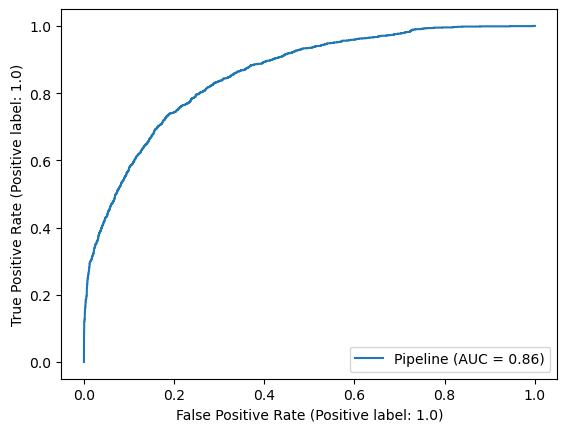

In [13]:
# ROC Curve
print("Logistic Regression")
plot_roc_curve(clf, x_test, y_test)

In [14]:
# Define SVM for Linear and RBF kernel (using C=1 and gamma=1/2)
## Linear
svc_linear = svm.SVC(kernel='linear', C=1, gamma=1/2)
svc_linear.fit(x_train, y_train)

## Polynomial - took too long to compute
#svc_poly = svm.SVC(kernel='poly', C=1,gamma= 1/2)
#svc_poly.fit(x_train, y_train)

## RBF
svc_rbf = svm.SVC(kernel='rbf', C=1,gamma= 1/2)
svc_rbf.fit(x_train, y_train)

SVC(C=1, gamma=0.5)

In [15]:
# Predict the score on test data
print("SVC Linear Prediction Score:", svc_linear.score(x_test, y_test))                  
print("SVC RBF Prediction Score:", svc_rbf.score(x_test, y_test))   

SVC Linear Prediction Score: 0.8165208045447566
SVC RBF Prediction Score: 0.8384768923691079


SVM Linear Kernel


C:\Users\Kanna\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


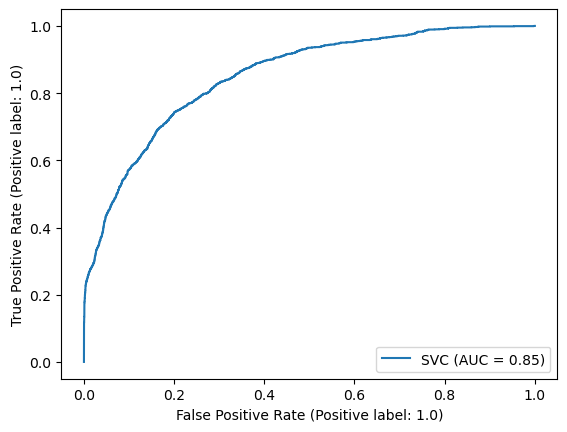

In [16]:
# ROC Curve
print("SVM Linear Kernel")
plot_roc_curve(svc_linear, x_test, y_test)

SVM RBF Kernel


C:\Users\Kanna\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


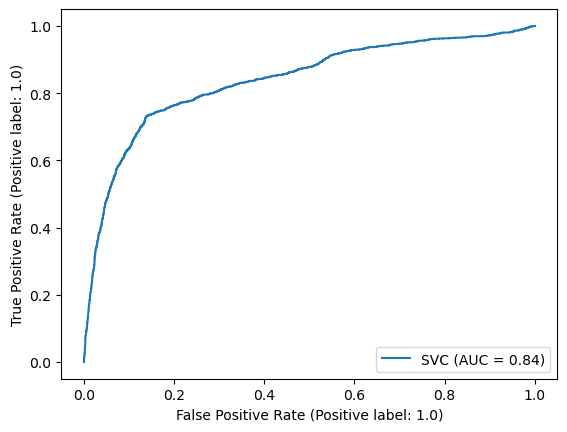

In [17]:
print("SVM RBF Kernel")
plot_roc_curve(svc_rbf, x_test, y_test)

**For overall comparison between prediction scores using different splits/methods, a table was created**

In [18]:
# Prediction Score Results for all 4 classification models
results = pd.DataFrame({'PredScore_80_20': [clf.score(x_test, y_test),
                                             svc_linear.score(x_test, y_test),                                             
                                             svc_rbf.score(x_test, y_test)]}, 
                        index=['LogisticRegression', 
                               'SVC_Linear',                                  
                               'SVC_RBF'])

print("Prediction Scores:\n", results)

Prediction Scores:
                     PredScore_80_20
LogisticRegression         0.825887
SVC_Linear                 0.816521
SVC_RBF                    0.838477


**Second split: 70-train and 30-test**

In [19]:
x_train, x_test, y_train, y_test = train_test_split(fts, tgt, 
                                                    test_size=0.30, 
                                                    random_state=42)

**Perform classification using models LogisticRegression and SVM kernels using all features**

In [20]:
# Logistic Regression
clf = make_pipeline(preprocessing.StandardScaler(),
                     LogisticRegressionCV(random_state=0, 
                                          solver='lbfgs', 
                                          multi_class='multinomial'))

clf1 = clf.fit(x_train, y_train)
print(clf1) 

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregressioncv',
                 LogisticRegressionCV(multi_class='multinomial',
                                      random_state=0))])


In [21]:
# Evaluate the model
clf_score1 = clf1.score(x_test, y_test)
print("LogisticRegression Prediction Score:", clf_score1)

LogisticRegression Prediction Score: 0.8263895997543249


Logistic Regression


C:\Users\Kanna\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


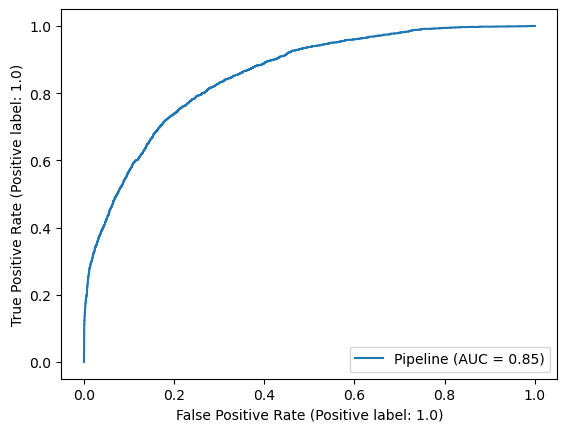

In [22]:
# ROC Curve
print("Logistic Regression")
plot_roc_curve(clf1, x_test, y_test)

In [23]:
# Define SVM for Linear and RBF kernel (using C=1 and gamma=1/2)
## Linear
svc_linear1 = svm.SVC(kernel='linear', C=1, gamma=1/2)
svc_linear1.fit(x_train, y_train)

## RBF
svc_rbf1 = svm.SVC(kernel='rbf', C=1,gamma= 1/2)
svc_rbf1.fit(x_train, y_train)

SVC(C=1, gamma=0.5)

In [24]:
# Predict the score on test data
linear_score1 = svc_linear1.score(x_test, y_test)
rbf_score1 = svc_rbf1.score(x_test, y_test)

print("SVC Linear Prediction Score:", linear_score1)                 
print("SVC RBF Prediction Score:", rbf_score1)

SVC Linear Prediction Score: 0.8209642747466476
SVC RBF Prediction Score: 0.8334527587265841


SVM Linear Kernel


C:\Users\Kanna\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


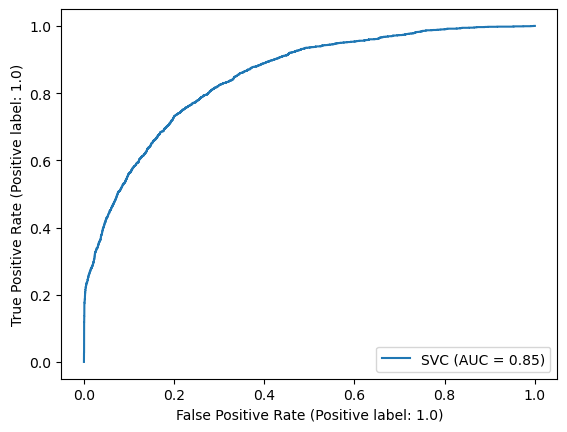

In [25]:
# ROC Curve
print("SVM Linear Kernel")
plot_roc_curve(svc_linear1, x_test, y_test)

SVM RBF Kernel


C:\Users\Kanna\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


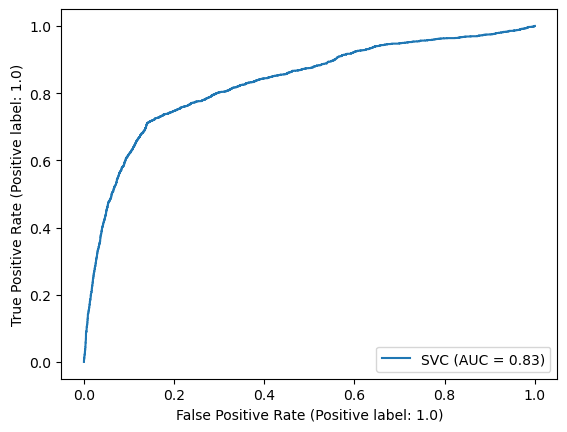

In [26]:
print("SVM RBF Kernel")
plot_roc_curve(svc_rbf1, x_test, y_test)

In [27]:
# Adding Prediction Scores to results table for comparison between 80/20 split and 70/30 split
results['PredScore_70_30'] = pd.Series([clf_score1,
                                         linear_score1,                                         
                                         rbf_score1],
                                        index=['LogisticRegression', 
                                               'SVC_Linear',                                                 
                                               'SVC_RBF'])

print("Prediction Scores:\n", results)

Prediction Scores:
                     PredScore_80_20  PredScore_70_30
LogisticRegression         0.825887         0.826390
SVC_Linear                 0.816521         0.820964
SVC_RBF                    0.838477         0.833453


> Since the prediction scores do not change or show a difference between the two splitted train/test datasets, an additional model classification is performed by selecting the best features only and see if there are any improvements in the model prediction. 

**Lasso-Regression model method**

In [28]:
# Perform GridSearchCV to tune best-fit LR model
param = {'C': [10**-3,10**-2,10**0,10**2,10**3]}

lr_model = LogisticRegression(penalty='l1', solver='liblinear')
gs_model = GridSearchCV(estimator=lr_model, param_grid=param)
gs_model.fit(x_train, y_train)

GridSearchCV(estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             param_grid={'C': [0.001, 0.01, 1, 100, 1000]})

In [29]:
# Train a LR model with best parameters
model = LogisticRegression(**gs_model.best_params_, penalty='l1', solver='liblinear')
model.fit(x_train, y_train)

LogisticRegression(C=1000, penalty='l1', solver='liblinear')

In [30]:
# Compute coefficients of Logistic Regression Model
coef = model.coef_[0]
print(coef)

[ 4.64969979e-01 -6.74997282e-02  3.31741678e-01 -2.35997547e-01
 -2.47931026e-04 -1.03085309e-01  1.18808187e-01  9.33955237e-01
  2.35821749e+00  2.61780288e-01  3.87997608e-01  4.01465850e-03]


**Recursive Feature Elimination (RFE)**

In [31]:
# Features and Target will be used
print("Features Set:\n", fts)
print("Target Set:\n", tgt)

# Print the column names of features for verification
print("Features Names:\n", fts.columns)

Features Set:
             age  workclass  education_num  marital_status  occupation  \
0      0.030671        7.0           12.0             4.0         0.0   
1      0.837109        6.0           12.0             2.0         3.0   
2     -0.042642        4.0            8.0             0.0         5.0   
3      1.057047        4.0            6.0             2.0         5.0   
4     -0.775768        4.0           12.0             2.0        10.0   
...         ...        ...            ...             ...         ...   
32556 -0.849080        4.0           11.0             2.0        13.0   
32557  0.103983        4.0            8.0             2.0         6.0   
32558  1.423610        4.0            8.0             6.0         0.0   
32559 -1.215643        4.0            8.0             4.0         0.0   
32560  0.983734        5.0            8.0             2.0         3.0   

       relationship  race  sex  capital_gain  capital_loss  hours_per_week  \
0               1.0   4.0  1.0

In [32]:
# Create a logistic regression model
model = LogisticRegression()

# Use RFE to select the top 10 features
rfe = RFE(model, n_features_to_select=8)
rfe.fit(fts, tgt)

C:\Users\Kanna\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RFE(estimator=LogisticRegression(), n_features_to_select=8)

In [33]:
# Print the selected features
print(rfe.support_)

[ True False  True  True False  True False  True  True  True  True False]


In [34]:
# Using the following selected features, train the model
imp_features = pd.Series(fts.columns)[list(rfe.support_)]
print(imp_features)

sel_fts = fts[imp_features]

0                age
2      education_num
3     marital_status
5       relationship
7                sex
8       capital_gain
9       capital_loss
10    hours_per_week
dtype: object


**Third Split: 70-train and 30-test using selected 8 features**

In [35]:
x_train, x_test, y_train, y_test = train_test_split(sel_fts, tgt, 
                                                    test_size=0.30, 
                                                    random_state=42)

**Perform classification using models LogisticRegression and SVM kernels using all features**

In [36]:
# Logistic Regression
clf = make_pipeline(preprocessing.StandardScaler(),
                     LogisticRegressionCV(random_state=0, 
                                          solver='lbfgs', 
                                          multi_class='multinomial'))

clf2 = clf.fit(x_train, y_train)
print(clf2) 

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregressioncv',
                 LogisticRegressionCV(multi_class='multinomial',
                                      random_state=0))])


In [37]:
# Evaluate the model
clf_score2 = clf2.score(x_test, y_test)
print("LogisticRegression Prediction Score:", clf_score2)

LogisticRegression Prediction Score: 0.826696693622684


Logistic Regression


C:\Users\Kanna\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


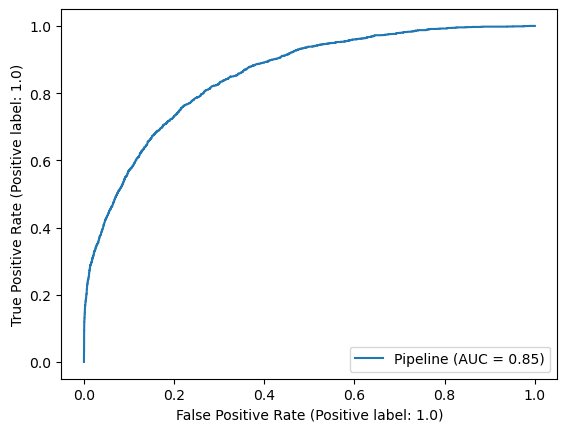

In [38]:
# ROC Curve
print("Logistic Regression")
plot_roc_curve(clf2, x_test, y_test)

In [39]:
# Define SVM for Linear and RBF kernel (using C=1 and gamma=1/2)
## Linear
svc_linear2 = svm.SVC(kernel='linear', C=1, gamma=1/2)
svc_linear2.fit(x_train, y_train)

## RBF
svc_rbf2 = svm.SVC(kernel='rbf', C=1,gamma= 1/2)
svc_rbf2.fit(x_train, y_train)

SVC(C=1, gamma=0.5)

In [40]:
# Predict the score on test data
linear_score2 = svc_linear2.score(x_test, y_test)
rbf_score2 = svc_rbf2.score(x_test, y_test)

print("SVC Linear Prediction Score:", linear_score2)                 
print("SVC RBF Prediction Score:", rbf_score2)

SVC Linear Prediction Score: 0.8200429931415703
SVC RBF Prediction Score: 0.8469648889343843


SVM Linear Kernel


C:\Users\Kanna\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


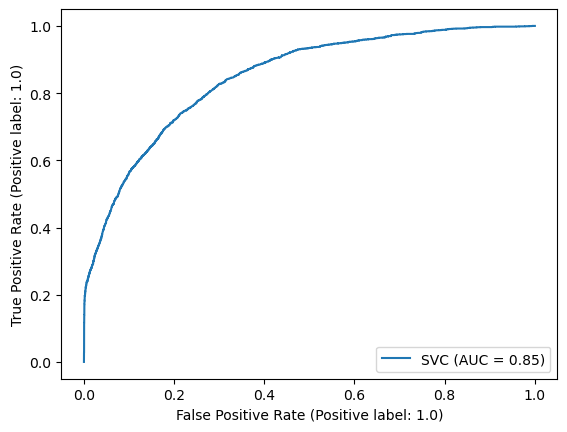

In [41]:
# ROC Curve
print("SVM Linear Kernel")
plot_roc_curve(svc_linear2, x_test, y_test)

SVM RBF Kernel


C:\Users\Kanna\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


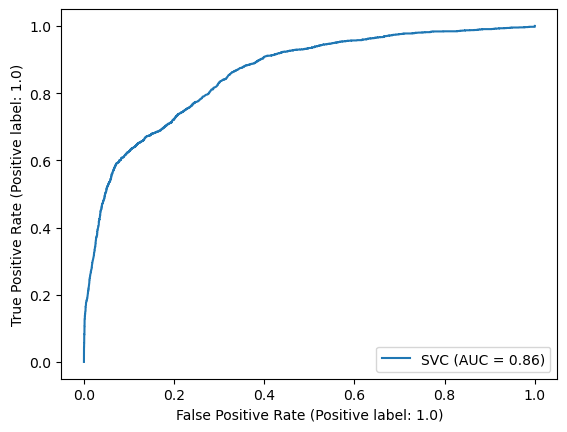

In [42]:
print("SVM RBF Kernel")
plot_roc_curve(svc_rbf2, x_test, y_test)

In [43]:
# Adding Prediction Scores to results table for further comparison 
results['RFE_Sel_70_30'] = pd.Series([clf_score2,
                                         linear_score2,                                         
                                         rbf_score2],
                                        index=['LogisticRegression', 
                                               'SVC_Linear',                                                 
                                               'SVC_RBF'])

print("Prediction Scores Table:\n", results)

Prediction Scores Table:
                     PredScore_80_20  PredScore_70_30  RFE_Sel_70_30
LogisticRegression         0.825887         0.826390       0.826697
SVC_Linear                 0.816521         0.820964       0.820043
SVC_RBF                    0.838477         0.833453       0.846965


### Create a bar chart for visual comparison of prediction scores across all three models.

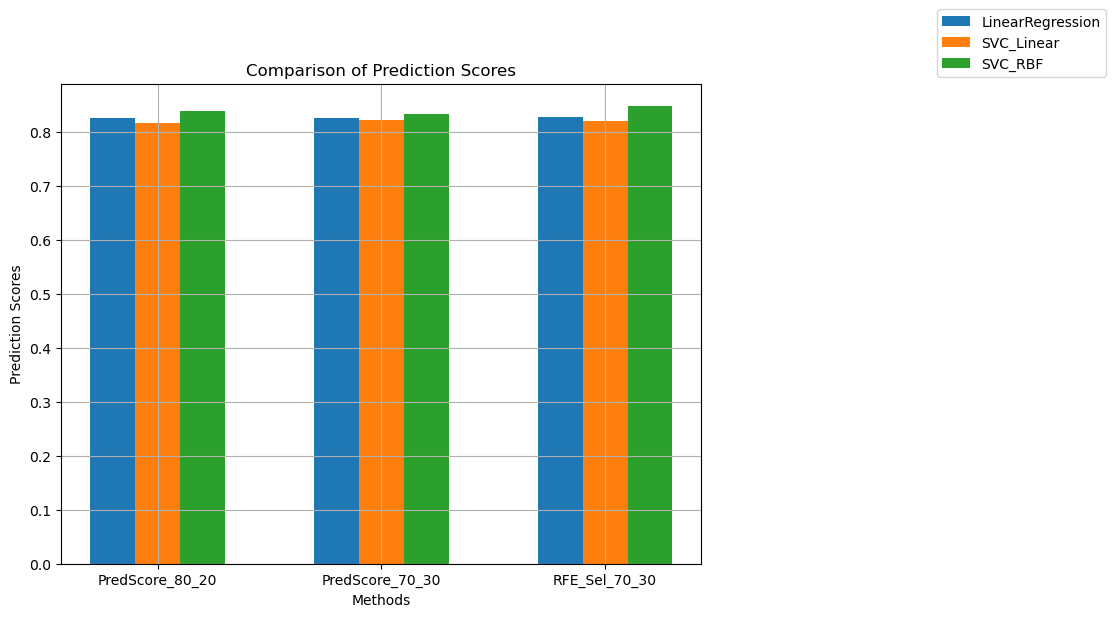

In [44]:
methods = ['PredScore_80_20', 'PredScore_70_30', 'RFE_Sel_70_30']
x = np.arange(len(methods))

lr = [0.8258866881621373, 0.8263895997543249, 0.826696693622684]
svc_ln = [0.8165208045447566, 0.8209642747466476, 0.8200429931415703]
svc_r = [0.8384768923691079, 0.8334527587265841, 0.8469648889343843]


width = 0.20

a = plt.figure()
ax = a.add_axes([0,0,1,1])
ax.set_title("Comparison of Prediction Scores")
ax.bar(x-0.2, lr, width)
ax.bar(x, svc_ln, width)
ax.bar(x+0.2, svc_r, width)

ax.legend(['LinearRegression', 'SVC_Linear', 'SVC_RBF'],
          loc = 'lower center', 
          bbox_to_anchor = (1.5,1.0))
ax.set_ylabel("Prediction Scores")
ax.set_xlabel("Methods")

plt.xticks(x, methods)
plt.grid()
plt.show()

<br>

> **FINAL RESULT STATEMENT**: 

> Based on the predictions score table created and displayed, SVC_RBF performs the best in predicting the outcome variable with a prediction score of 0.846965. Out of the three methods performed, when splitting the train/test by 70-30, the model that continuously performed the best was SVC RBF kernel. Visually, by looking at the displayed graph of prediction scores, it also can be seen that this model performs the best across all three methods, where the prediction score is higher. When looking solely at the SVC RBF kernel models, when selecting the best 8 features using Recursive Feature Elimination (RFE) feature selection technique, this had performed better in comparison to the other fitted models. The top 8 selected features that impact the model performance the most were age, education number classification, marital status, relationship, sex, capital income gain, capital income loss, and working hours per week. After numerous trials in order to find the best machine learning classification model, comparing all the performed model predictions, the SVC RBF kernel classification combined with RFE had performed the best in determining whether or not an individual's income exceeds $50k per year.